# Resume Screening - Applicant Tracking System (ATS)

Henry Yost, Riya Ashok, Angelina Jordan, Gokul Giridharan, and Refugio Zepeda Jr

## Project Outline

[Presentation Link](https://docs.google.com/presentation/d/1MTr2Wf4u3LQDxWHD8F7vfF0gIcAztHeYNlShb_iOBdg/edit?usp=sharing)

Objective:

In this project our objective is to create a resume screening system that helps automate the process of sorting through the resumes and ranking them based on how well they align with a job application in their field. 

Phase #1 (Filtering)

So first using the resume.csv file we are going to classify the 24 job categories into 5-6 buckets and save each file as a csv, so that we can combine certain jobs that tend to have the same broader term like tech and health. Which helps reduce the count from all the resumes in resume.csv into more manageable csv files that will be easier to use. The next step in the process is to find a job description for each bucket/csv file, so that we can compare the job descriptions with the different resume buckets. The next step will be to run RegEx on each of the buckets, which will clean up the text in the resumes by removing punctuation, spaces, special characters, HTML tags, and more. After using RegEx to clean up the data we can use hard criteria like certain skills needed, and essentially eliminate the resumes that don't fit the hard criteria, which gives us an easier dataset to work with. The next step is to use SBert to turn the text of the resumes and the job descriptions into vectors of fixed size, which allows us to capture the meaning of the text.

Phase #2 (Ideal Resume Filtering)

Using the vectors that we got from running SBert, we compute the cosine similarity between the vector of the resume and the vector of the job description. The cosine similarity test will tell us whether or not the resume is what the employer is looking for. In the next phase we are going to pick a couple of the best resumes(3-5) per job description. Then convert each of the best selected resumes into vectors using SBert, and then compute the average of those vectors into a singular vector, which would represent the center of all the resumes for a job category. Then using this centroid, compare all the new resumes to said centroid, using the cosine similarity score. The higher the score = the closer the resume is to the ideal cluster of resumes. We are doing this so that, instead of matching one resume to another we are matching a type of resume to another, which is a much better baseline. 

Phase #3 (Human Labeling & Supervised Training)

Then we look through the top resumes that we are left with and manually decide whether or not the resume is qualified using 1s and 0s and these will become our training label for our supervised learning model. Though this might be a tedious process, we think that it will be very effective in the long run. Next we train a Logistic Regression model using the vectorized resumes courtesy of SBert as the input and the training label that we manually made in the last step. This model will learn what an ideal resume should look like. Then we train a Naive Bayes Model using TF-IDF to convert the resumes into vectors as our input and the labels that we previously found before as our labels. This model will learn which words are common between qualified and unqualified resumes, and will output the probability of the resume being qualified or not. Then we combine the two models using soft voting, which is when we average the predicted probabilities from both models, which will improve our final decision.

## Dataset Exploration & Variables in the Dataset
The main dataset that we are using is Resume.csv from Kaggle, and this dataset contains over 2484 resumes, each labeled with a specific job category. The dataset was approved by the professor, as we are doing a unique project.

* **ID** – The ID is the unique identifier for each resume
* **Resume_str** – The content/words of the resume (including formatting)
* **Resume_html** – The contents of the resume in HTML format
* **Category** – The labeled job field for the respective resume (HR, Tech, Finance, Aviation...)

[Dataset Link](https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset)

### Plan

1. Classify 24 categories into 5-6 meaningful buckets
3. Save each bucket as a new CSV file
4. Find a Job Description (i.e., Software Engineer @ Apple) and use the most closely related CSV file/dataframe (Tech)
5. Preprocess the resumes (lowercasing, removing symbols, indents, etc) using RegEx and Python functions

**Phase 1:** Basic Filtering
1. Use RegEx and hard criteria to filter resumes
2. Convert resumes and job descriptions to SBERT embeddings and compute the  cosine similarity score.

**Phase 2:** Ideal Resume Comparison & Human Labeling
1. Pick multiple IDEAL resumes for the position (let's say the person is leaving, pick multiple ideal resumes for said position)
2. Compute the average embedding and compare new resumes to the centroid of the ideal cluster
3. A human looks through the top resumes and marks them as qualified or not, in addition to considering their similarity to the ideal cluster

**Phase 3:** Supervised Training
1. Train the SVM that we code (we code the architecture) on embeddings
2. Train SVM from the library on the same embeddings
3. Compare outputs
4. Combine via soft voting, rank fusion, or stacking (not sure which one would work best)

## Libraries
For this project, we are using a handful of specific libraries. Please make sure you already have them installed in your conda environment, or run the 'pip install'.

* Pandas, Numpy, 
* Re
* SentenceTransformer
* Numpy

In [7]:
# Installing additional libraries
!pip install -U -q sentence-transformers
!pip install -q wordcloud

In [8]:
# Library Importing
import pandas as pd
import re #RegEx

# First stage resume cleaning
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import math as math
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns

## 1. Importing Dataset & Cleaning

In [10]:
df_orig = pd.read_csv("Data/Resume.csv")
df_orig = df_orig.drop("Resume_html", axis=1) # Drop HTML, because we do not need it

# All possible categories: HR, Designer, Information-Technology, Teacher, Advocate, Business-Development, 
# Healthcare, Fitness, Agriculture, BPO, Sales, Consultant, Digital-Media, Automobile, Chef, 
# Finance, Apparel, Engineering, Accountant, Construction, Public Relations, Banking, Arts, Aviation

# Separate into approx 5 meaningful buckets
df_tech = df_orig[df_orig['Category'].isin(['INFORMATION-TECHNOLOGY', 'ENGINEERING', 'DIGITAL-MEDIA', 'HR'])]
df_tech = df_tech.copy()

df_health_well = df_orig[df_orig['Category'].isin(['HEALTHCARE', 'FITNESS'])]
df_health_well = df_health_well.copy()

df_bus_fin = df_orig[df_orig['Category'].isin(['BUSINESS-DEVELOPMENT', 'SALES', 'CONSULTANT', 'FINANCE', 'ACCOUNTANT', 'BANKING'])]
df_bus_fin = df_bus_fin.copy()

df_creative_public = df_orig[df_orig['Category'].isin(['ARTS', 'DESIGNER', 'PUBLIC-RELATIONS', 'TEACHER', 'ADVOCATE'])]
df_creative_public = df_creative_public.copy()

df_indust = df_orig[df_orig['Category'].isin(['AGRICULTURE', 'AUTOMOBILE', 'CONSTRUCTION', 'AVIATION', 'BPO'])]
df_indust = df_indust.copy()

df_misc = df_orig[df_orig['Category'].isin(['CHEF', 'APPAREL'])]
df_misc = df_misc.copy()

# Write each bucket to a CSV
df_tech.to_csv("Output_csv/tech.csv")
df_health_well.to_csv("Output_csv/health_wellness.csv")
df_bus_fin.to_csv("Output_csv/business_finance.csv")
df_creative_public.to_csv("Output_csv/creative_public.csv")
df_indust.to_csv("Output_csv/industrial.csv")
df_misc.to_csv("Output_csv/miscellaneous.csv")

In [11]:
# Using RegEx to clean the Resume strings
def clean_resume(text):
    text = text.lower() # Make everything lowercase.
    text = re.sub(r'\s+', ' ', text) # replaces whitespace characters with a single space.
    text = re.sub(r'\/+', ' ', text) # replaces / characters with a single space (some resumes use backslashes)
    text = re.sub(r'[^a-z0-9\s\.\,\-]', '', text) # keeps letters, numbers, whitespace, periods, and dashes.
    text = re.sub(r'\s+', ' ', text).strip() # replaces leading and trailing whitespace characters.
    return text

df_tech.loc[:, "Cleaned_str"] = df_tech["Resume_str"].apply(clean_resume)
df_health_well.loc[:, "Cleaned_str"] = df_health_well["Resume_str"].apply(clean_resume)
df_bus_fin.loc[:, "Cleaned_str"] = df_bus_fin["Resume_str"].apply(clean_resume)
df_creative_public.loc[:, "Cleaned_str"] = df_creative_public["Resume_str"].apply(clean_resume)
df_indust.loc[:, "Cleaned_str"] = df_indust["Resume_str"].apply(clean_resume)
df_misc.loc[:, "Cleaned_str"] = df_misc["Resume_str"].apply(clean_resume)

# Also, there are no NaN values, so we don't need to drop any rows.

df_tech.head()

,ID,Resume_str,Category,Cleaned_str
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administrator marketing associate hr admini...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,"hr specialist, us hr operations summary versat..."
2,33176873,HR DIRECTOR Summary Over 2...,HR,hr director summary over 20 years experience i...
3,27018550,HR SPECIALIST Summary Dedica...,HR,"hr specialist summary dedicated, driven, and d..."
4,17812897,HR MANAGER Skill Highlights ...,HR,hr manager skill highlights hr skills hr depar...


## 4. Exploratory Data Analysis (EDA)

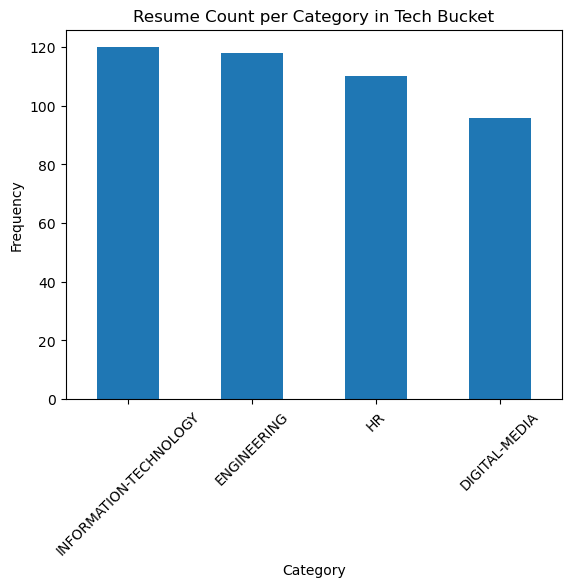

In [13]:
tech_count = df_tech['Category'].value_counts()
tech_count.plot(kind='bar')
plt.title("Resume Count per Category in Tech Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

**Analysis:**

Index(['ID', 'Resume_str', 'Category', 'Cleaned_str'], dtype='object')
Index(['ID', 'Resume_str', 'Category', 'Cleaned_str'], dtype='object')
Index(['ID', 'Resume_str', 'Category', 'Cleaned_str'], dtype='object')


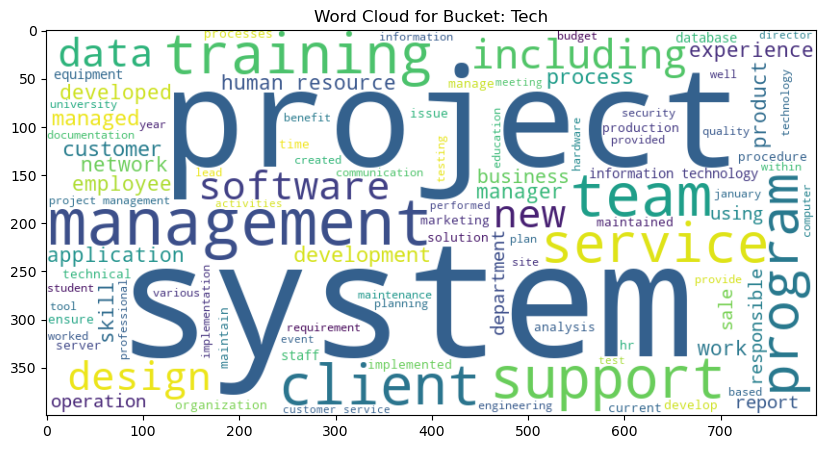

In [15]:
from collections import Counter
print(df_tech.columns)
print(df_bus_fin.columns)
print(df_health_well.columns)

texts = ' '.join(df_tech["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Tech")
plt.show()

**Analysis:**

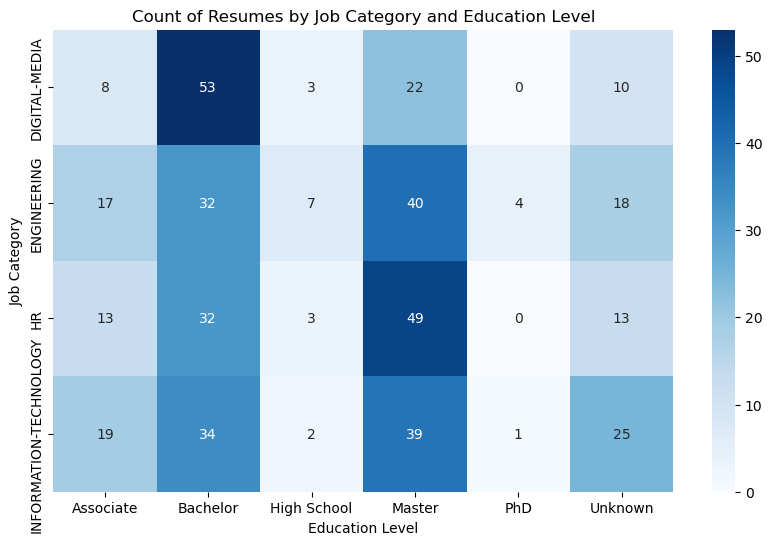

In [17]:
#library
education_levels = {
    'PhD': ['phd', 'doctor of philosophy'],
    'Master': ['master', 'masters', 'msc', 'mba'],
    'Bachelor': ['bachelor', 'bachelors', 'bsc', 'ba'],
    'Associate': ['associate', 'associates'],
    'High School': ['high school', 'ged']
}


def extract_education_level(texts):
    texts = texts.lower()
    for level, keywords in education_levels.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', texts):
                return level
    return 'Unknown'

#Apply the function onto resume string to create a new row 
df_tech['education_level'] = df_tech['Resume_str'].apply(extract_education_level)

heatmap_data = pd.crosstab(df_tech['Category'], df_tech['education_level'])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='d')
plt.title('Count of Resumes by Job Category and Education Level')
plt.ylabel('Job Category')
plt.xlabel('Education Level')
plt.show()

**Analysis:**

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


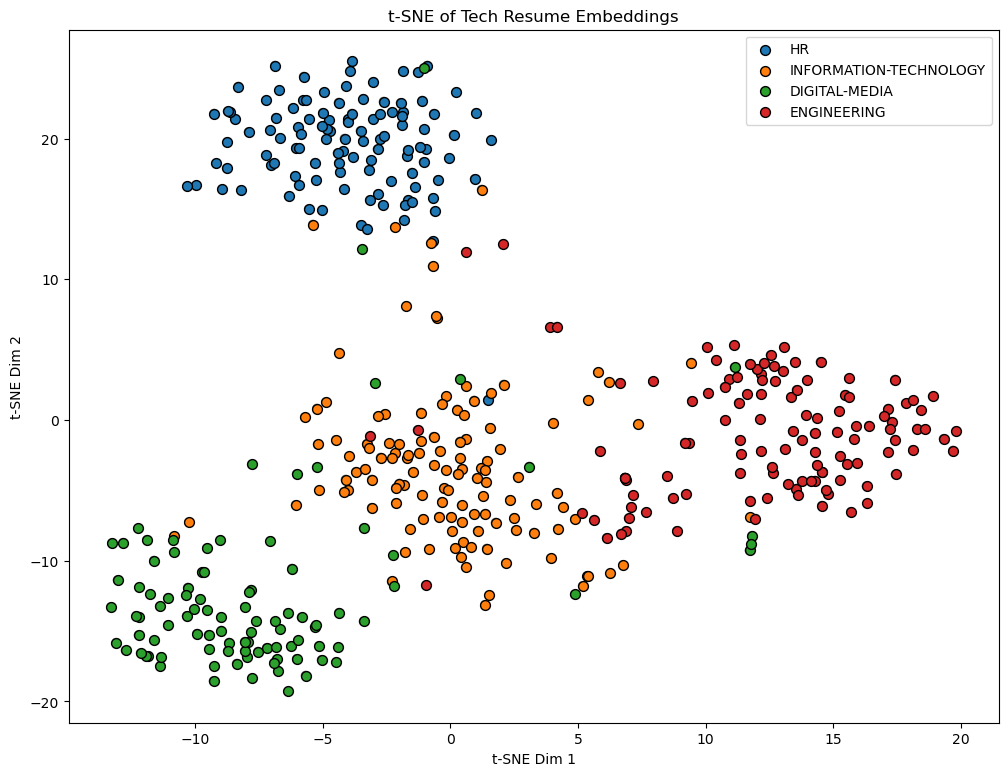

In [19]:
# Graphing resume embeddings with computed similarity
# https://medium.com/analytics-vidhya/visualising-embeddings-with-t-sne-b54bf6b635f\

m_SBERT = SentenceTransformer('all-MiniLM-L6-v2')

resume_embeddings = df_tech['Cleaned_str'].apply(lambda x: m_SBERT.encode(x))
tech_embeddings = np.vstack(resume_embeddings)

# Perplexity is too high, so update it to a number between 5 and 30 based on neighbors
n_samples = tech_embeddings.shape[0]
l_perplexity = min(30, max(2, math.floor(n_samples / 3)))

tsne = TSNE(random_state = 0, max_iter = 1000, metric = 'cosine', perplexity = l_perplexity)
tnse_fitted = tsne.fit_transform(tech_embeddings)

df_tnse_fitted = pd.DataFrame()

# Add ID and cosine similarity
df_tnse_fitted['Category'] = df_tech['Category']
categories = df_tnse_fitted['Category'].astype('category')
color_codes = categories.cat.codes

df_tnse_fitted['X'] = tnse_fitted[:,0]
df_tnse_fitted['Y'] = tnse_fitted[:,1]

# Plot everything
plt.figure(figsize=(12, 9))
scatter = plt.scatter(df_tnse_fitted['X'], df_tnse_fitted['Y'], c = color_codes, edgecolors='black', alpha=0.5)

# I had to use ChatGPT for this part because honestly, I have no idea how to do this and couldn't find a way
unique_categories = df_tnse_fitted['Category'].unique()
colors = plt.cm.tab10.colors

# Loop through each category to plot them one by one
for idx, category in enumerate(unique_categories):
    subset = df_tnse_fitted[df_tnse_fitted['Category'] == category]
    plt.scatter(
        subset['X'], subset['Y'],
        color=colors[idx % len(colors)],
        edgecolors='black',
        label=category,
        s=50
    )
# Till this part

# Axis labels and title
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE of Tech Resume Embeddings")
plt.legend()
plt.show()

**t-SNE Visualization of Resume Embeddings:** 
This graph is a visual representation of the flattened SBERT embeddings of the tech resumes. The position of the resumes is based on their embeddings, thus the closer to the eachother, means the two are semantically more similar. Thus, points clustered around eachother means they have greater semantic similarity.

**Analysis:**

# Tesla Software and Energy Engineer
## Selecting the IDEAL position Resume's
These resumes were selected as the best matches for the position. For instance, if an employee left the company and the role became vacant, these two resumes represent the ideal candidates the company would seek to fill that position.

These resumes were selecting by filtering through the dataset, and finding a number of resumes that we felt best matched the experience, roles, and skills of someone in said position.

In [22]:
ideal_resume_ID = [82246962, 12472574]

if df_tech['ID'].isin(ideal_resume_ID).any():
    df_ideal = df_tech[df_tech['ID'].isin(ideal_resume_ID)].copy()
    df_tech = df_tech[~df_tech['ID'].isin(ideal_resume_ID)]
df_ideal.head()

,ID,Resume_str,Category,Cleaned_str,education_level
1695,82246962,TEST ENGINEERING Profile I a...,ENGINEERING,test engineering profile i am seeking the chal...,Associate
1802,12472574,QA ENGINEERING TEAM LEAD Care...,ENGINEERING,qa engineering team lead career overview eight...,Unknown


## 1. First Resume Cleaning Cycle

In [24]:
# Extracting related fields from job description

# Move to file potentially
# https://www.linkedin.com/jobs/view/4239183377
tesla_job_desc = (
    "Develop, enhance and debug new and existing real-time software in C/C++ in embedded RTOS environments. "
    "Work with HW and system teams on building testing infrastructure. Help design and bring up state of the art HIL/SIL validation infrastructure. "
    "Help implement software tests for HIL/SIL infrastructure. Assist in tool development for testing and system integration. "
    "Own implementation of software/firmware features end to end. What You'll Bring "
    "Pursuing a Degree in Computer Science, Electrical Engineering, Physics or related field. "
    "Desired to have strong understanding of Python debug simple circuits. "
    "Desired to have good electrical and electronics fundamentals to be able to understand schematics and desired to have test driven development mindset. "
    "Remain engaged, proactive and positive while solving very challenging problems. "
    "Own assignments and take full accountability for overall team success. "
    "Capable of delivering top quality C/C++ code for embedded systems."
)

# Grab fields using regex and the tagline "Pursuing a Degree in...". The RegEx captures everything up to the period and groups it into Group 1.
degree_requirements = re.search(r"Pursuing a Degree in (.+?)(?:\.|$)", tesla_job_desc, re.IGNORECASE)

# We assume (because we are picking the Job Descriptions) that they all have some form of requirements
# Thus, now we can compare each resume in the dataframe and check if they are pursuing a degree in the xyz field.

# Split on commas, and's or or's
degree_fields = re.split(r',\s*| and | or ', degree_requirements.group(1))

# More processing on the actual degrees
degree_fields = [i.strip().lower() for i in degree_fields]
degree_fields.remove("related field")

print("Extracted fields:", degree_fields)

Extracted fields: ['computer science', 'electrical engineering', 'physics']


In [25]:
# Additionally, we need to remove the 'related fields' tag in the split and also replace it with potential related fields
related_fields = ['software engineering', 'computer engineering', 'mechanical engineering', 'data science', 'robotics', 'information technology', 'applied physics']
degree_fields = degree_fields + related_fields
print("Extracted fields:", degree_fields)

Extracted fields: ['computer science', 'electrical engineering', 'physics', 'software engineering', 'computer engineering', 'mechanical engineering', 'data science', 'robotics', 'information technology', 'applied physics']


In [26]:
# Now we check if the actual resumes have any variation of these fields in them
def resume_degree_matching(resume):
    for degree in degree_fields:
        if degree in resume:
            return True
    return False

df_tech['matching_degree'] = df_tech['Cleaned_str'].apply(resume_degree_matching)
df_tech_match = df_tech[df_tech['matching_degree'] == True].copy()

In [27]:
# Load a pre-trained SBERT model (https://sbert.net/)
m_SBERT = SentenceTransformer('all-MiniLM-L6-v2')

tesla_job_embeddings = m_SBERT.encode(tesla_job_desc)

def compute_similarity(resume):
    resume_embeddings = m_SBERT.encode(resume)
    similarity = cosine_similarity([resume_embeddings], [tesla_job_embeddings])[0][0]
    return similarity

df_tech_match['Computed_similarity'] = df_tech_match['Cleaned_str'].apply(compute_similarity)

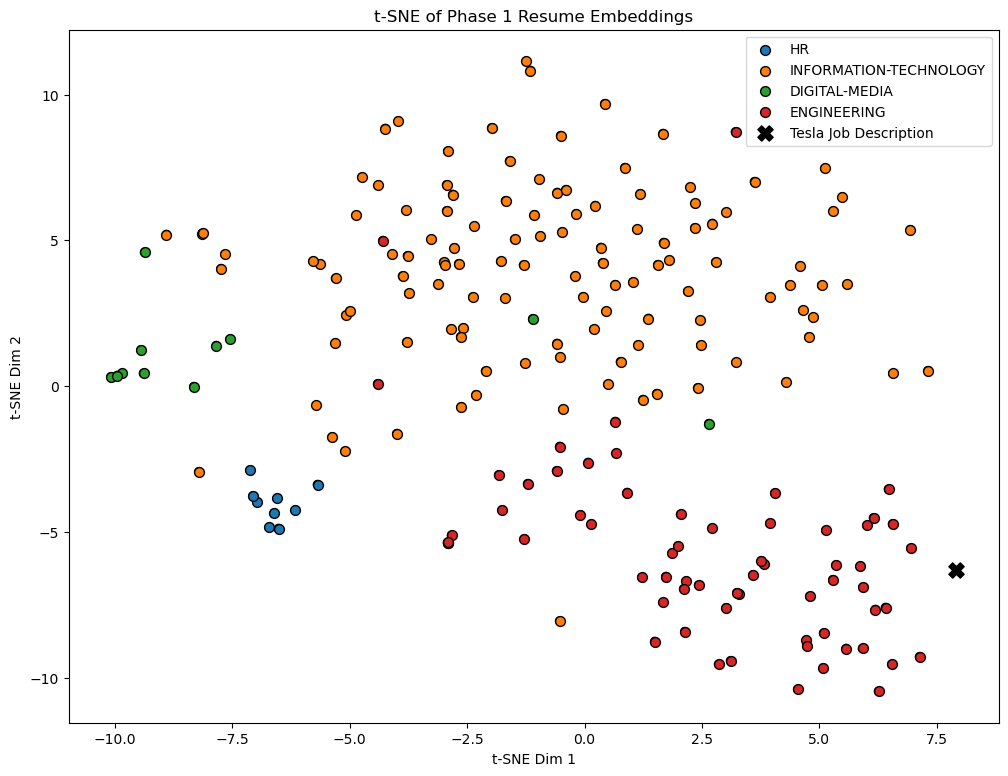

In [28]:
# Graphing resume embeddings with computed similarity
# https://medium.com/analytics-vidhya/visualising-embeddings-with-t-sne-b54bf6b635f

resume_embeddings = df_tech_match['Cleaned_str'].apply(lambda x: m_SBERT.encode(x))
resume_embeddings = np.vstack(resume_embeddings)
all_embeddings = np.vstack([resume_embeddings, tesla_job_embeddings])

# Perplexity is too high, so update it to a number between 5 and 30 based on neighbors
n_samples = all_embeddings.shape[0]
l_perplexity = min(30, max(2, math.floor(n_samples / 3)))

tsne = TSNE(random_state = 0, max_iter = 1000, metric = 'cosine', perplexity = l_perplexity)
tnse_fitted = tsne.fit_transform(all_embeddings)

df_tnse_fitted = pd.DataFrame()

# Add ID and cosine similarity
df_tnse_fitted['Category'] = df_tech_match['Category']
categories = df_tnse_fitted['Category'].astype('category')
color_codes = categories.cat.codes

df_tnse_fitted['X'] = tnse_fitted[:-1,0]
df_tnse_fitted['Y'] = tnse_fitted[:-1,1]

# Job description
x_job = tnse_fitted[-1, 0]
y_job = tnse_fitted[-1, 1]

# Plot everything
plt.figure(figsize=(12, 9))
scatter = plt.scatter(df_tnse_fitted['X'], df_tnse_fitted['Y'], c = color_codes, edgecolors='black')

# I had to use ChatGPT for this part because honestly, I have no idea how to do this and couldn't find a way
unique_categories = df_tnse_fitted['Category'].unique()
colors = plt.cm.tab10.colors

# Loop through each category to plot them one by one
for idx, category in enumerate(unique_categories):
    subset = df_tnse_fitted[df_tnse_fitted['Category'] == category]
    plt.scatter(
        subset['X'], subset['Y'],
        color=colors[idx % len(colors)],
        edgecolors='black',
        label=category,
        s=50
    )
# Till this part

# Plotting job position embeddings as a marker
plt.scatter(x_job, y_job, color='black', marker='X', s=120, label='Tesla Job Description', zorder=10)

# Axis labels and title
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE of Phase 1 Resume Embeddings")
plt.legend()
plt.show()

**t-SNE Visualization of Resume Embeddings and Job Description:** 
This graph is a visual representation of the flattened SBERT embeddings of the closest resumes in terms of similarity. In addition to the SBERT embeddings of the Job description (marked by an `X`). Additionally, similar to the previous graph, the position of the resumes is based on their embeddings; thus, the closer to the job description, means the two are semantically more similar.

**Analysis:**

In [30]:
# If over a similarity threshold, add to a new dataframe
df_tech_cleaned = df_tech_match[df_tech_match['Computed_similarity'] >= 0.43].copy()
df_tech_cleaned.info()
df_tech_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 222 to 1799
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   38 non-null     int64  
 1   Resume_str           38 non-null     object 
 2   Category             38 non-null     object 
 3   Cleaned_str          38 non-null     object 
 4   education_level      38 non-null     object 
 5   matching_degree      38 non-null     bool   
 6   Computed_similarity  38 non-null     float32
dtypes: bool(1), float32(1), int64(1), object(4)
memory usage: 2.0+ KB


,ID,Resume_str,Category,Cleaned_str,education_level,matching_degree,Computed_similarity
222,91635250,Christopher Townes Summa...,INFORMATION-TECHNOLOGY,christopher townes summary knowledgeable infor...,Unknown,True,0.445310
224,15651486,DIRECTOR OF INFORMATION TECHNOLOGY ...,INFORMATION-TECHNOLOGY,director of information technology career over...,Associate,True,0.432384
225,52246737,INFORMATION TECHNOLOGY PROVISIONING T...,INFORMATION-TECHNOLOGY,information technology provisioning technician...,Associate,True,0.440459
248,19201175,INFORMATION TECHNOLOGY SPECIALIST ...,INFORMATION-TECHNOLOGY,information technology specialist summary rece...,High School,True,0.440903
253,22450718,INFORMATION TECHNOLOGY SPECIALIST ...,INFORMATION-TECHNOLOGY,information technology specialist professional...,Bachelor,True,0.432311


## 2. Second Resume Cleaning Cycle

In [32]:
df_ideal.head()

,ID,Resume_str,Category,Cleaned_str,education_level
1695,82246962,TEST ENGINEERING Profile I a...,ENGINEERING,test engineering profile i am seeking the chal...,Associate
1802,12472574,QA ENGINEERING TEAM LEAD Care...,ENGINEERING,qa engineering team lead career overview eight...,Unknown


In [33]:
# calculate average embeddings of the IDEAL resumes
def average_embeddings(subset):
    avg_embeddings = subset['Cleaned_str'].apply(lambda x: m_SBERT.encode(x))
    matrix_embeddings = np.vstack(avg_embeddings)
    avg = np.mean(matrix_embeddings, axis = 0)
    return avg

ideal_embeddings = average_embeddings(df_ideal)

#print(ideal_embeddings)

In [34]:
def p2_compute_similarity(resume):
    resume_embeddings = m_SBERT.encode(resume)
    similarity = cosine_similarity([resume_embeddings], [ideal_embeddings])[0][0]
    return similarity

df_tech_cleaned['Phase2_computed_similarity'] = df_tech_cleaned['Cleaned_str'].apply(p2_compute_similarity)
df_tech_cleaned.head()
df_tech_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 222 to 1799
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          38 non-null     int64  
 1   Resume_str                  38 non-null     object 
 2   Category                    38 non-null     object 
 3   Cleaned_str                 38 non-null     object 
 4   education_level             38 non-null     object 
 5   matching_degree             38 non-null     bool   
 6   Computed_similarity         38 non-null     float32
 7   Phase2_computed_similarity  38 non-null     float32
dtypes: bool(1), float32(2), int64(1), object(4)
memory usage: 2.1+ KB


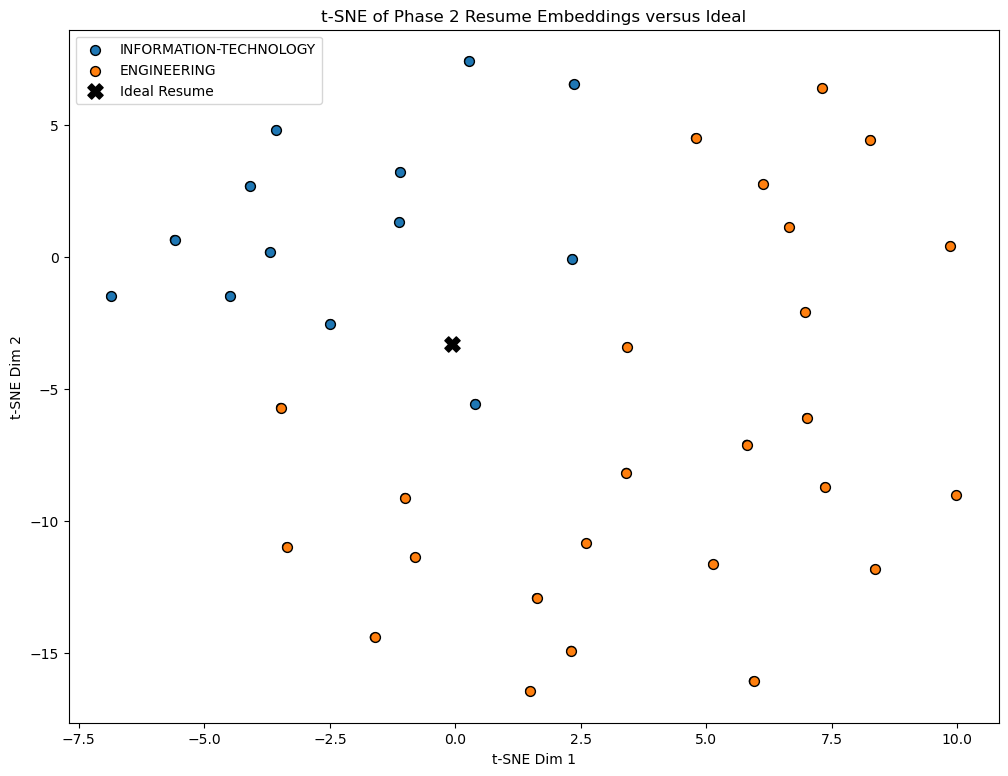

In [35]:
# Graphing resume embeddings with computed similarity
# https://medium.com/analytics-vidhya/visualising-embeddings-with-t-sne-b54bf6b635f

resume_embeddings = df_tech_cleaned['Cleaned_str'].apply(lambda x: m_SBERT.encode(x))
resume_embeddings = np.vstack(resume_embeddings)
all_embeddings = np.vstack([resume_embeddings, ideal_embeddings])

# Perplexity is too high, so update it to a number between 5 and 30 based on neighbors
n_samples = all_embeddings.shape[0]
l_perplexity = min(30, max(2, math.floor(n_samples / 3)))

tsne = TSNE(random_state = 0, max_iter = 1000, metric = 'cosine', perplexity = l_perplexity)
tnse_fitted = tsne.fit_transform(all_embeddings)

df_tnse_fitted = pd.DataFrame()

# Add ID and cosine similarity
df_tnse_fitted['Category'] = df_tech_cleaned['Category']
categories = df_tnse_fitted['Category'].astype('category')
color_codes = categories.cat.codes

df_tnse_fitted['X'] = tnse_fitted[:-1,0]
df_tnse_fitted['Y'] = tnse_fitted[:-1,1]

# Ideal resume embeddings
x_ideal = tnse_fitted[-1, 0]
y_ideal = tnse_fitted[-1, 1]

# Plot everything
plt.figure(figsize=(12, 9))
scatter = plt.scatter(df_tnse_fitted['X'], df_tnse_fitted['Y'], c = color_codes, edgecolors='black')

# I had to use ChatGPT for this part because honestly, I have no idea how to do this and couldn't find a way
unique_categories = df_tnse_fitted['Category'].unique()
colors = plt.cm.tab10.colors

# Loop through each category to plot them one by one
for idx, category in enumerate(unique_categories):
    subset = df_tnse_fitted[df_tnse_fitted['Category'] == category]
    plt.scatter(
        subset['X'], subset['Y'],
        color=colors[idx % len(colors)],
        edgecolors='black',
        label=category,
        s=50
    )
# Till this part

# Plotting job position embeddings as a marker
plt.scatter(x_ideal, y_ideal, color='black', marker='X', s=120, label='Ideal Resume', zorder=10)

# Axis labels and title
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE of Phase 2 Resume Embeddings versus Ideal")
plt.legend()
plt.show()

## 3. Third Resume Cleaning Cycle & SVM Training

In [37]:
# Train SVM on synthetic lables

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

m_SBERT = SentenceTransformer('all-MiniLM-L6-v2')
resume_embeddings = df_tech_cleaned['Cleaned_str'].apply(lambda x: m_SBERT.encode(x))
resume_embeddings = np.vstack(resume_embeddings)

encoder = OneHotEncoder(sparse_output=False)
education_encoded = encoder.fit_transform(df_tech_cleaned[['education_level']])

print(len(resume_embeddings))
print(len(education_encoded))

X = np.hstack([resume_embeddings, education_encoded])
#y = df_tech_cleaned['Category']
#all_embeddings = np.vstack([resume_embeddings, ideal_embeddings])
#n_samples = all_embeddings.shape[0]
#l_perplexity = min(30, max(2, math.floor(n_samples / 3)))
#tsne = TSNE(random_state = 0, max_iter = 1000, metric = 'cosine', perplexity = l_perplexity)
# tnse_fitted = tsne.fit_transform(all_embeddings)
# df_tnse_fitted = pd.DataFrame()
# df_tnse_fitted['Category'] = df_tech_cleaned['Category']
# df_tnse_fitted['X'] = tnse_fitted[:-1,0]
# df_tnse_fitted['Y'] = tnse_fitted[:-1,1]


# X_tsne = df_tnse_fitted[['X', 'Y']]
# y_tsne = df_tnse_fitted['Category']



38
38


In [39]:
import numpy as np

n_samples = len(X)
n_classes = 2
y_synthetic = np.random.randint(0, n_classes, size=n_samples)
X_train, X_test, y_train_synthetic, y_test_synthetic = train_test_split(
    X, y_synthetic, test_size=5, random_state=42)

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train_synthetic)

SVC()

In [41]:
from sklearn.metrics import accuracy_score, classification_report
y_pred_synthetic = svm_model.predict(X_test)

accuracy = accuracy_score(y_test_synthetic, y_pred_synthetic)
report = classification_report(y_test_synthetic, y_pred_synthetic)

print(f"Accuracy (using synthetic labels): {accuracy}")
print("Classification Report (using synthetic labels):")
print(report)

Accuracy (using synthetic labels): 0.4
Classification Report (using synthetic labels):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
import numpy as np

#The model for binary classification
class SVM:
    def init(self, learning_rate = 0.001, lambda_param=0.01, n_itters=1000):
        self.lr = learning_rate                 #Contols how fast the model updates
        self.lambda_param = lambda_param        #reguliazation strength to prevent overfitting
        self.n_iters = n_itters                 #Number of training loops
        self.weight = None                      #Model coefficients
        self.bias = None                        #Bias used to offset for decision bouindary 

    def fit(self, X, y):
        n_samples, nfeatures = X.shape         #number of samples(rows), features(columns)

        y = np.where(y <= 0, -1, 1)            #convert y to either -1 or 1
        self.weight = np.zeros(nfeatures)      #initilaize to 0
        self.bias = 0                           #initilaize to 0

        #training loop
        for _ in range(self.n_iters):
            for idx, xi in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.weight) - self.bias) >= 1 #checks to current sample is correclty classified
                if condition: 
                    self.weight -= self.lr * (2 * self.lambda_param * self.weight) #if correct onlt regulize
                else: 
                    self.weight -= self.lr * (2 * self.lambda_param * self.weight - np.dot(xi, y[idx])) #if incorrected put both gradient and regulize
                    self.bias -=  self.lr * y_[idx]

    def predict(self, X):                             #used to preficted if qualied or not qualified 
        approx = np.dot(X, self.weight) - self.bias 
        return np.sign(approx)

    def decision_function(self, X):
        return np.dot(X, self.weight) - self.bias    #finally classifies if it goes with -1 or 1 group